# Import libraries

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML preprocessing/optimizing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import shap


# Scoring
from sklearn.metrics import roc_auc_score

# Data formatting/preprocessing
import time 
import tqdm
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# NaN Imputer
from sklearn.impute import KNNImputer



# Ml models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb


### Advanse optimizing (HyperOpt Parameter Tuning)
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

## Useful
pd.set_option('display.max_columns', None)

%matplotlib inline 

# Part 1. Data preprocessing

## Reading data

In [60]:
with open('train_part1.pkl', 'rb') as f1:
    train_part1 = pickle.load(f1)

with open('train_part2.pkl', 'rb') as f2:
    train_part2 = pickle.load(f2)
    
with open('test_data.pkl', 'rb') as f3:
    test_data = pickle.load(f3)

## Distribution of target

In [33]:
train_part1.TARGET.value_counts()

0    732535
1     31266
Name: TARGET, dtype: int64

In [34]:
train_part2.TARGET.value_counts()

0    732074
1     31723
Name: TARGET, dtype: int64

#### We can see class disbalance problem

# Shapes

In [35]:
train_part1.shape

(763801, 648)

In [36]:
train_part2.shape

(763797, 648)

#### the same

# Plan

- проделать препроцессинг для второй части трайн сета
- построить shap values
- обучить градиентынй бустинг
- пофитить гиперпараметры (random search + hyperopt)
- засабмитить первый скор

# Numeric data preprocess

In [62]:
def preprocess_data(data):
    '''
    Fill nans and label encode
    '''
    for i, col in enumerate(data.columns[1:]):
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            #joblib.dump(le, MODELS_PATH + f'le_{col}.pkl')
    return data

def numeric_preprocess(data):
    """This function operates with numerical data,
    it fills na with mean values and replaces inf by nan and reduces them"""
    
    data = data.select_dtypes(include=np.number).apply(lambda x: x.fillna(x.mean()),axis=0)
    data = data.select_dtypes(include=np.number)
    data = data.set_index('ID')
    
    cat_columns = data.columns[data.nunique() < 10]
    num_columns = data.columns[data.nunique() >= 10]
    data = pd.concat([ data[cat_columns].fillna(data[cat_columns].mode().iloc[0,:]), data[num_columns].fillna(data[num_columns].mean()) ], axis=1)
    data = preprocess_data(data)
    return data





### Concatenate two train parts

In [38]:
numeric_data = pd.concat([numeric_preprocess(train_part1), numeric_preprocess(train_part2)], axis = 0)

In [39]:
# numeric_data = numeric_preprocess(train_part1)
# numeric_data = numeric_data.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)

# Non numeric preprocess

In [40]:
def non_numeric_preprocess(data):
    """This function handles with non numeric data (only 18 columns)
    It is worth mention that mapping part required additional analysis"""
    
    # set id as index
    data = data.set_index('ID')
    
    # Exclude numerics but not target
    target = data['TARGET']
    data = data.select_dtypes(exclude=np.number)
    data = pd.concat([data, target], axis = 1)
    
    # count the duration of cradit period
    data['period'] = (data['REPORT_DT'] - data['x_9']).dt.days
    
    # drop lot significant feeatures
    data = data.drop(['x_617', 'x_618','x_17', 'x_25', 'x_26', 'x_27', 'REPORT_DT', 'x_9'], axis = 1)
    
    return data

def rating_mean(data, name):
    """This function provides us with a dataframe that contains mean values of target.
    We will use the to encide categorical features"""
    
    a = []
    for i in data.select_dtypes(exclude=np.number)['{}'.format(name)].unique():
        a.append(data[data['{}'.format(name)] == i].TARGET.mean())

    res = pd.DataFrame([data.select_dtypes(exclude=np.number)['{}'.format(name)].unique(), a])    
    res=res.T.sort_values(by = 1)
    return res

def mapping_non_numerics(data_resource, data_final):
    """Here we use 2 data bases for proper categorical feature encoding (non overlaping)"""
    
    # handle with binaries
    #binaries = ['x_19', 'x_614', 'x_615', 'x_634']
    #data_final[binaries] = data_final[binaries].apply(pd.to_numeric)
    
    # x_12 client significance
    mapping = rating_mean(data_resource, 'x_12').set_index(0).to_dict()[1]
    data_final['x_12'].replace(mapping, inplace=True)
    
    # x_18

    
    not_weekend = data_resource[((data_resource['x_18'] != 'Вс') & (data_resource['x_18'] != 'Сб'))].TARGET.mean()
    weekend = data_resource[((data_resource['x_18'] == 'Вс') | (data_resource['x_18'] == 'Сб'))].TARGET.mean()
    map_18 = {'Вс':weekend, 
         'Сб':weekend,
         'Пн':not_weekend,
         'Чт':not_weekend,
         'Вт':not_weekend,
         'Пт':not_weekend,
         'Ср':not_weekend}
    
    data_final['x_18'].replace(map_18, inplace=True)
    
    # x_13
    map_x_13 = rating_mean(data_resource, 'x_13')
    not_1 = data_resource[data_resource['x_13'] != '1'].TARGET.mean()
    map_13 = {'1':map_x_13.iloc[2,1], 
             '2':not_1,
             '3':not_1,
             '4':not_1,
             '5':not_1,
             '9':not_1,
             '19':not_1}
    
    data_final['x_13'].replace(map_13, inplace=True)
    
    # x_21
    x_21 = rating_mean(data_resource, 'x_21')
    map_21 = x_21.set_index(0).to_dict()[1]
    data_final['x_21'].replace(map_21, inplace=True)
    
    # x_625 town or not
    x_625 = rating_mean(data_resource, 'x_625')
    map_625 = x_625.set_index(0).to_dict()[1]
    data_final['x_625'].replace(map_625, inplace=True)
    
    # x_628
    x_628 = rating_mean(data_resource, 'x_628')
    map_628 = x_628.set_index(0).to_dict()[1]
    data_final['x_628'].replace(map_628, inplace=True)
    

## Lets check, how mean target is connected with categorical features

In [41]:
for i in train_part1.select_dtypes(exclude=np.number).columns:
    try:
        print('non numeric feature {}'.format(i))
        print(rating_mean(train_part1, i))
        print("##############################################")
    except ValueError: 
        pass

non numeric feature REPORT_DT
             0         1
513 2017-04-07       0.0
813 2017-08-25       0.0
814 2018-09-14       0.0
815 2018-03-31       0.0
816 2019-01-12       0.0
..         ...       ...
13  2017-07-03  0.068541
440 2017-04-10  0.069372
749 2017-07-10  0.070243
286 2017-08-29  0.074457
657 2017-03-06  0.083333

[1028 rows x 2 columns]
##############################################
non numeric feature x_9
              0      1
1595 2015-01-06    0.0
690  2017-07-08    0.0
1663 2016-09-25    0.0
1662 2012-10-26    0.0
1661 2017-06-11    0.0
...         ...    ...
1644 2012-06-14  0.625
1636 2016-01-24    0.9
1834 2014-08-31    1.0
1869 2013-10-20    1.0
1872 2013-05-01    1.0

[1873 rows x 2 columns]
##############################################
non numeric feature x_12
    0         1
6  A1  0.019427
3   A  0.030718
0  B1   0.03394
5   B  0.042134
1   D  0.049258
4   C  0.050675
2   N  0.059137
##############################################
non numeric feature x_13
 

## Change the categorical values by mapping avoiding overlapping

In [42]:
train_1_base = non_numeric_preprocess(train_part1.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1))
train_1_final = train_1_base.copy()
train_2_base = non_numeric_preprocess(train_part2)
train_2_final = train_2_base.copy()

mapping_non_numerics(train_2_base, train_1_final)
mapping_non_numerics(train_1_base, train_2_final)

In [43]:
cat_data = pd.concat([train_1_final, train_2_final], axis = 0)

In [44]:
cat_data = cat_data.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)

In [45]:
cat_data.rename(columns={'x_12':'client_significance', 'x_18':'day_of_week', 'x_21':'credit_purpose',
                            'x_625':'city', 'x_628':'street'}, inplace = True)

# Combining (already non) catigorical and numerical training data

#### both dataframes contain TARGET, so one we will remove


In [46]:
train = numeric_data.drop(['TARGET'], axis = 1).merge(cat_data, left_index=True, right_index=True)

##### x_0 and x_1 are meaningless so drop them

In [47]:
train = train.drop(['x_0', 'x_1'], axis = 1)

## Correlation between target and numerical features

In [48]:
features = train.drop(['TARGET'], axis = 1)
target = train['TARGET']

In [49]:
cols = features.select_dtypes(include=np.number).columns
l = []
for i in range(len(cols)):
    l.append(target.corr(train.loc[:,cols[i]]))

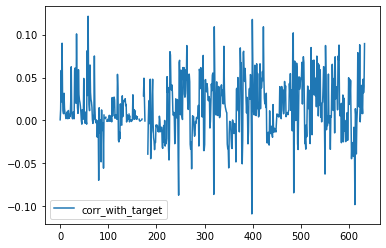

In [50]:
corr_data = pd.DataFrame([cols, l]).T.iloc[:,:]
corr_data = corr_data.rename(columns={0:'feature', 1:'corr_with_target'})
corr_data['corr_with_target'] = pd.to_numeric(corr_data['corr_with_target'])
corr_data.plot();

In [51]:
corr_data

,feature,corr_with_target
0,x_2,0.000651
1,x_3,0.012819
2,x_57,0.058172
3,x_79,0.021659
4,x_80,0.090000
...,...,...
628,day_of_week,0.007803
629,credit_purpose,0.048008
630,city,0.032274
631,street,0.040244


### Plot top 15 the most correlated and the least

In [52]:
corr_data.nlargest(15, 'corr_with_target')

,feature,corr_with_target
58,x_286,0.121455
399,x_292,0.117702
320,x_189,0.109134
422,x_330,0.109114
484,x_421,0.102047
34,x_183,0.100839
4,x_80,0.090000
632,period,0.089535
622,x_643,0.088186
579,x_584,0.087823


In [53]:
corr_data.nsmallest(15, 'corr_with_target')

,feature,corr_with_target
398,x_291,-0.109110
612,x_630,-0.098233
246,x_85,-0.087254
319,x_188,-0.086354
485,x_422,-0.084480
80,x_346,-0.069847
550,x_543,-0.062622
273,x_134,-0.056502
90,x_370,-0.055744
350,x_237,-0.055434


#### The idea is that simple linear correlation can tell us what features have more significant linear dependence - these features from the first point of view are better and should be chosen

## Facts from categorical data

- Looks like weekends positively reflects on credibility 
 (maybe because people working during the week and can receive a credit only on the weekends)
- client status matters (A1 - N)
- living in city matters (city -> more income -> better credibility)
- more period -> more default rate!
- loan on street -> more default rate
- credit purpose matters!

#### provement for days of week 

In [54]:
a = []
for i in train_part1.select_dtypes(exclude=np.number).x_18.unique():
    a.append(train_part1[train_part1['x_18'] == i].TARGET.mean())

res = pd.DataFrame([train_part1.select_dtypes(exclude=np.number).x_18.unique(), a])    
res.T.sort_values(by = 1)

,0,1
6,Вс,0.031562
5,Сб,0.035158
0,Пн,0.039736
1,Чт,0.040383
4,Вт,0.040936
3,Пт,0.04275
2,Ср,0.043311


# Test data preparation

In [55]:
test_data

,REPORT_DT,x_0,x_1,x_2,x_3,x_4,x_5,x_7,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,x_80,x_81,x_82,x_83,x_84,x_85,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,x_109,x_110,x_111,x_112,x_113,x_114,x_115,x_116,x_117,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_158,x_159,x_160,x_161,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_182,x_183,x_184,x_185,x_186,x_187,x_188,x_189,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_204,x_205,x_206,x_207,x_208,x_209,x_210,x_211,x_212,x_213,x_214,x_215,x_216,x_217,x_218,x_219,x_220,x_221,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_263,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_280,x_281,x_282,x_283,x_284,x_285,x_286,x_287,x_288,x_289,x_290,x_291,x_292,x_293,x_294,x_295,x_296,x_297,x_298,x_299,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_308,x_309,x_310,x_311,x_312,x_313,x_314,x_315,x_316,x_317,x_318,x_319,x_320,x_321,x_322,x_323,x_324,x_325,x_326,x_327,x_328,x_329,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_340,x_341,x_342,x_343,x_344,x_345,x_346,x_347,x_348,x_349,x_350,x_351,x_352,x_353,x_354,x_355,x_356,x_357,x_358,x_359,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_367,x_368,x_369,x_370,x_371,x_372,x_373,x_374,x_375,x_376,x_377,x_378,x_379,x_380,x_381,x_382,x_383,x_384,x_385,x_386,x_387,x_388,x_389,x_390,x_391,x_392,x_393,x_394,x_395,x_396,x_397,x_398,x_399,x_400,x_401,x_402,x_403,x_404,x_405,x_406,x_407,x_408,x_409,x_410,x_411,x_412,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_420,x_421,x_422,x_423,x_424,x_425,x_426,x_427,x_428,x_429,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_439,x_440,x_441,x_442,x_443,x_444,x_445,x_446,x_447,x_448,x_449,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_467,x_468,x_469,x_470,x_471,x_472,x_473,x_474,x_475,x_476,x_477,x_478,x_479,x_480,x_481,x_482,x_483,x_484,x_485,x_486,x_487,x_488,x_489,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_500,x_501,x_502,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_510,x_511,x_512,x_513,x_514,x_515,x_516,x_517,x_518,x_519,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_527,x_528,x_529,x_530,x_531,x_532,x_533,x_534,x_535,x_536,x_537,x_538,x_539,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_550,x_551,x_552,x_553,x_554,x_555,x_556,x_557,x_558,x_559,x_560,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_568,x_569,x_570,x_571,x_572,x_573,x_574,x_575,x_576,x_577,x_578,x_579,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_608,x_609,x_610,x_611,x_612,x_613,x_614,x_615,x_616,x_617,x_618,x_619,x_620,x_621,x_622,x_623,x_624,x_625,x_626,x_627,x_628,x_629,x_630,x_631,x_632,x_633,x_634,x_635,x_636,x_637,x_638,x_639,x_640,x_641,x_642,x_643,x_644,x_645,x_646,ID
1943531,2019-09-01,1,0,1,1,1100000.0,157773.90,157773.90,2014-10-25,1000000.0,120,D,4,37,2.0,2.0,None,Сб,0,0.00,Приобретение,120,1000000.0,1270000.0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [56]:
def non_numeric_preprocess_test(data):
    """This function handles with non numeric data (only 18 columns)
    It is worth mention that mapping part required additional analysis"""
    
    # set id as index
    data = data.set_index('ID')
    
    # Exclude numerics but not target
    #target = data['TARGET']
    data = data.select_dtypes(exclude=np.number)
    #data = pd.concat([data, target], axis = 1)
    
    # count the duration of cradit period
    data['period'] = (data['REPORT_DT'] - data['x_9']).dt.days
    
    # drop lot significant feeatures
    data = data.drop(['x_617', 'x_618','x_17', 'x_25', 'x_26', 'x_27', 'REPORT_DT', 'x_9'], axis = 1)
    
    return data

In [170]:
numeric_test_data = numeric_preprocess(test_data)
numeric_test_data = numeric_test_data.drop(['x_0', 'x_1'], axis = 1)


test_cat = non_numeric_preprocess_test(test_data)
test_cat.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)
mapping_non_numerics(train_2_base, test_cat)
test_cat = test_cat.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)
test_cat.rename(columns={'x_12':'client_significance', 'x_18':'day_of_week', 'x_21':'credit_purpose',
                            'x_625':'city', 'x_628':'street'}, inplace = True)

test = numeric_test_data.merge(test_cat, left_index=True, right_index=True)

## Shapes of train and test detesets corresponds (test does not contain target)

In [64]:
test.shape

(763809, 633)

In [59]:
train.shape

(1527548, 634)

In [37]:
train
cat_columns = train.columns[train.nunique() < 10]
num_columns = train.columns[train.nunique() >= 10]
train[cat_columns] = train[cat_columns].fillna(train[cat_columns].mode().iloc[0,:]) 


# Part 2. Machine Learning

In [92]:
train = train.replace([np.inf, -np.inf], np.nan).dropna()

In [208]:
X = train.drop(['TARGET'], axis = 1)
y = train['TARGET']

### PCA

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
X_new = pca.fit_transform(X)

In [94]:
X = pd.DataFrame(X_new)

### Train test split

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Logreg

In [100]:
from sklearn.linear_model import LogisticRegression


clf_logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf_logreg.predict_proba(X_test)


roc_auc_score(y_test, y_pred[:,1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7007812498206312

In [79]:
from sklearn.linear_model import LogisticRegression


clf_logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf_logreg.predict_proba(X_test)


roc_auc_score(y_test, y_pred[:,1])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6915412802112906

### ICA

In [ ]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=25)
X.drop(['x_13'], axis = 1, inplace = True)

X_ica = transformer.fit_transform(X)

In [ ]:
X = pd.DataFrame(X_ica)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
from sklearn.linear_model import LogisticRegression


clf_logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf_logreg.predict_proba(X_test)


roc_auc_score(y_test, y_pred[:,1])

### Lightgbm + randomsearch

In [ ]:
from random import randint
from random import uniform


model_lgb = lgb.LGBMClassifier(random_state=0)

distributions = {'learning_rate':[0.000001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
                 'max_depth' :[2,3,4,5],
                 'n_estimators':[100,200, 300, 400, 600],
                 'boosting_type':['gbdt', 'dart', 'goss', 'rf'],
                 'random_state':[0],
                 'importance_type':['split', 'gain'],
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model_lgb_1 = RandomizedSearchCV(model_lgb, distributions, random_state=0, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
model_lgb_1 = model_lgb_1.fit(X_train, y_train)


In [125]:
y_pred_proba_lgb = model_lgb_1.best_estimator_.predict_proba(X_test)

In [128]:
roc_auc_score(y_test, y_pred[:,1])

0.8623433984999345

In [ ]:
0.8623433984999345

### Catboost + randomsearch

In [132]:
model_ctb = ctb.CatBoostClassifier(random_state=0)



distributions = {'learning_rate':[0.000001, 0.0001, 0.001, 0.01,0.05, 0.1, 0.5, 1],
                 'depth' :[1,2,3,4,5],
                 'l2_leaf_reg': [1, 3, 5, 7, 9], 'iterations':[100, 200, 300, 500]}

model_ctb_1 = RandomizedSearchCV(model_ctb, distributions, random_state=0, verbose=2, n_iter = 5, cv = 3)
model_ctb_1 = model_ctb_1.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.05, l2_leaf_reg=1, iterations=200, depth=5 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6145706	total: 66.9ms	remaining: 13.3s
1:	learn: 0.5553858	total: 120ms	remaining: 11.8s
2:	learn: 0.5028983	total: 168ms	remaining: 11s
3:	learn: 0.4582036	total: 214ms	remaining: 10.5s
4:	learn: 0.4197509	total: 265ms	remaining: 10.4s
5:	learn: 0.3866075	total: 326ms	remaining: 10.5s
6:	learn: 0.3560872	total: 406ms	remaining: 11.2s
7:	learn: 0.3275901	total: 467ms	remaining: 11.2s
8:	learn: 0.3070679	total: 519ms	remaining: 11s
9:	learn: 0.2891797	total: 585ms	remaining: 11.1s
10:	learn: 0.2711699	total: 667ms	remaining: 11.5s
11:	learn: 0.2577359	total: 719ms	remaining: 11.3s
12:	learn: 0.2433918	total: 775ms	remaining: 11.1s
13:	learn: 0.2330090	total: 849ms	remaining: 11.3s
14:	learn: 0.2223322	total: 932ms	remaining: 11.5s
15:	learn: 0.2151095	total: 986ms	remaining: 11.3s
16:	learn: 0.2070694	total: 1.05s	remaining: 11.3s
17:	learn: 0.2017362	total: 1.12s	remaining: 11.3s
18:	learn: 0.1966613	total: 1.18s	remaining: 11.2s
19:	learn: 0.1912730	total: 1.24s	remaining:

164:	learn: 0.1431186	total: 12.4s	remaining: 2.63s
165:	learn: 0.1430636	total: 12.5s	remaining: 2.56s
166:	learn: 0.1430347	total: 12.6s	remaining: 2.48s
167:	learn: 0.1430069	total: 12.6s	remaining: 2.4s
168:	learn: 0.1429777	total: 12.7s	remaining: 2.33s
169:	learn: 0.1429469	total: 12.7s	remaining: 2.25s
170:	learn: 0.1428958	total: 12.8s	remaining: 2.17s
171:	learn: 0.1428705	total: 12.8s	remaining: 2.09s
172:	learn: 0.1428390	total: 12.9s	remaining: 2.01s
173:	learn: 0.1428100	total: 13s	remaining: 1.94s
174:	learn: 0.1427760	total: 13s	remaining: 1.86s
175:	learn: 0.1427356	total: 13.1s	remaining: 1.78s
176:	learn: 0.1427035	total: 13.1s	remaining: 1.7s
177:	learn: 0.1426722	total: 13.2s	remaining: 1.63s
178:	learn: 0.1426284	total: 13.2s	remaining: 1.55s
179:	learn: 0.1426019	total: 13.3s	remaining: 1.48s
180:	learn: 0.1425656	total: 13.3s	remaining: 1.4s
181:	learn: 0.1425292	total: 13.4s	remaining: 1.32s
182:	learn: 0.1424967	total: 13.4s	remaining: 1.25s
183:	learn: 0.14246

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


0:	learn: 0.6145906	total: 64.5ms	remaining: 12.8s
1:	learn: 0.5553650	total: 115ms	remaining: 11.4s
2:	learn: 0.5035677	total: 164ms	remaining: 10.8s
3:	learn: 0.4588398	total: 221ms	remaining: 10.8s
4:	learn: 0.4188513	total: 273ms	remaining: 10.6s
5:	learn: 0.3851877	total: 340ms	remaining: 11s
6:	learn: 0.3557263	total: 422ms	remaining: 11.6s
7:	learn: 0.3313005	total: 492ms	remaining: 11.8s
8:	learn: 0.3096980	total: 575ms	remaining: 12.2s
9:	learn: 0.2897513	total: 635ms	remaining: 12.1s
10:	learn: 0.2741472	total: 691ms	remaining: 11.9s
11:	learn: 0.2576382	total: 763ms	remaining: 11.9s
12:	learn: 0.2453828	total: 818ms	remaining: 11.8s
13:	learn: 0.2350366	total: 871ms	remaining: 11.6s
14:	learn: 0.2243441	total: 925ms	remaining: 11.4s
15:	learn: 0.2169332	total: 977ms	remaining: 11.2s
16:	learn: 0.2100353	total: 1.03s	remaining: 11.1s
17:	learn: 0.2044225	total: 1.09s	remaining: 11.1s
18:	learn: 0.1991453	total: 1.15s	remaining: 10.9s
19:	learn: 0.1948445	total: 1.2s	remaining

162:	learn: 0.1431455	total: 9.97s	remaining: 2.26s
163:	learn: 0.1431140	total: 10s	remaining: 2.2s
164:	learn: 0.1430722	total: 10.1s	remaining: 2.14s
165:	learn: 0.1430368	total: 10.1s	remaining: 2.08s
166:	learn: 0.1430071	total: 10.2s	remaining: 2.01s
167:	learn: 0.1429627	total: 10.2s	remaining: 1.95s
168:	learn: 0.1429206	total: 10.3s	remaining: 1.89s
169:	learn: 0.1428903	total: 10.3s	remaining: 1.82s
170:	learn: 0.1428676	total: 10.4s	remaining: 1.76s
171:	learn: 0.1428339	total: 10.5s	remaining: 1.7s
172:	learn: 0.1428035	total: 10.5s	remaining: 1.64s
173:	learn: 0.1427625	total: 10.6s	remaining: 1.58s
174:	learn: 0.1427362	total: 10.6s	remaining: 1.52s
175:	learn: 0.1426982	total: 10.7s	remaining: 1.46s
176:	learn: 0.1426680	total: 10.7s	remaining: 1.4s
177:	learn: 0.1426297	total: 10.8s	remaining: 1.33s
178:	learn: 0.1425953	total: 10.8s	remaining: 1.27s
179:	learn: 0.1425725	total: 10.9s	remaining: 1.21s
180:	learn: 0.1425425	total: 11s	remaining: 1.15s
181:	learn: 0.14251

120:	learn: 0.1449314	total: 8.23s	remaining: 5.38s
121:	learn: 0.1448881	total: 8.3s	remaining: 5.31s
122:	learn: 0.1448330	total: 8.38s	remaining: 5.25s
123:	learn: 0.1447700	total: 8.46s	remaining: 5.19s
124:	learn: 0.1447039	total: 8.54s	remaining: 5.12s
125:	learn: 0.1446067	total: 8.6s	remaining: 5.05s
126:	learn: 0.1445610	total: 8.67s	remaining: 4.98s
127:	learn: 0.1444995	total: 8.75s	remaining: 4.92s
128:	learn: 0.1444641	total: 8.83s	remaining: 4.86s
129:	learn: 0.1444065	total: 8.89s	remaining: 4.79s
130:	learn: 0.1443608	total: 8.96s	remaining: 4.72s
131:	learn: 0.1443120	total: 9.02s	remaining: 4.65s
132:	learn: 0.1442747	total: 9.08s	remaining: 4.58s
133:	learn: 0.1442141	total: 9.14s	remaining: 4.5s
134:	learn: 0.1441603	total: 9.19s	remaining: 4.42s
135:	learn: 0.1441143	total: 9.23s	remaining: 4.34s
136:	learn: 0.1440791	total: 9.29s	remaining: 4.27s
137:	learn: 0.1440371	total: 9.34s	remaining: 4.2s
138:	learn: 0.1440028	total: 9.4s	remaining: 4.12s
139:	learn: 0.143

80:	learn: 0.1338576	total: 4.51s	remaining: 6.63s
81:	learn: 0.1337871	total: 4.57s	remaining: 6.57s
82:	learn: 0.1336840	total: 4.62s	remaining: 6.51s
83:	learn: 0.1336108	total: 4.67s	remaining: 6.45s
84:	learn: 0.1335395	total: 4.73s	remaining: 6.4s
85:	learn: 0.1334540	total: 4.79s	remaining: 6.35s
86:	learn: 0.1333590	total: 4.84s	remaining: 6.29s
87:	learn: 0.1332856	total: 4.9s	remaining: 6.24s
88:	learn: 0.1331859	total: 4.96s	remaining: 6.19s
89:	learn: 0.1330861	total: 5.02s	remaining: 6.13s
90:	learn: 0.1330115	total: 5.09s	remaining: 6.1s
91:	learn: 0.1329353	total: 5.17s	remaining: 6.06s
92:	learn: 0.1328767	total: 5.24s	remaining: 6.03s
93:	learn: 0.1327852	total: 5.3s	remaining: 5.98s
94:	learn: 0.1326959	total: 5.38s	remaining: 5.94s
95:	learn: 0.1326284	total: 5.45s	remaining: 5.91s
96:	learn: 0.1325630	total: 5.53s	remaining: 5.87s
97:	learn: 0.1324587	total: 5.59s	remaining: 5.81s
98:	learn: 0.1323543	total: 5.66s	remaining: 5.77s
99:	learn: 0.1322384	total: 5.72s	r

38:	learn: 0.1387754	total: 2.3s	remaining: 9.48s
39:	learn: 0.1386435	total: 2.38s	remaining: 9.52s
40:	learn: 0.1384689	total: 2.44s	remaining: 9.45s
41:	learn: 0.1383237	total: 2.49s	remaining: 9.36s
42:	learn: 0.1381770	total: 2.55s	remaining: 9.32s
43:	learn: 0.1380339	total: 2.62s	remaining: 9.28s
44:	learn: 0.1377930	total: 2.71s	remaining: 9.32s
45:	learn: 0.1376230	total: 2.77s	remaining: 9.27s
46:	learn: 0.1374991	total: 2.84s	remaining: 9.25s
47:	learn: 0.1373725	total: 2.9s	remaining: 9.18s
48:	learn: 0.1372755	total: 2.97s	remaining: 9.15s
49:	learn: 0.1371615	total: 3.04s	remaining: 9.12s
50:	learn: 0.1370343	total: 3.1s	remaining: 9.05s
51:	learn: 0.1369365	total: 3.15s	remaining: 8.96s
52:	learn: 0.1368047	total: 3.2s	remaining: 8.88s
53:	learn: 0.1367184	total: 3.29s	remaining: 8.88s
54:	learn: 0.1366009	total: 3.34s	remaining: 8.82s
55:	learn: 0.1364845	total: 3.4s	remaining: 8.74s
56:	learn: 0.1363663	total: 3.46s	remaining: 8.69s
57:	learn: 0.1362835	total: 3.52s	re

[CV]  learning_rate=1, l2_leaf_reg=9, iterations=200, depth=4, total=  12.2s
[CV] learning_rate=1, l2_leaf_reg=9, iterations=200, depth=4 .........
0:	learn: 0.1663747	total: 71.4ms	remaining: 14.2s
1:	learn: 0.1565049	total: 147ms	remaining: 14.5s
2:	learn: 0.1537246	total: 204ms	remaining: 13.4s
3:	learn: 0.1514873	total: 270ms	remaining: 13.3s
4:	learn: 0.1497059	total: 334ms	remaining: 13s
5:	learn: 0.1487846	total: 395ms	remaining: 12.8s
6:	learn: 0.1480720	total: 447ms	remaining: 12.3s
7:	learn: 0.1472258	total: 507ms	remaining: 12.2s
8:	learn: 0.1465331	total: 580ms	remaining: 12.3s
9:	learn: 0.1459208	total: 634ms	remaining: 12s
10:	learn: 0.1454708	total: 692ms	remaining: 11.9s
11:	learn: 0.1446656	total: 767ms	remaining: 12s
12:	learn: 0.1443454	total: 861ms	remaining: 12.4s
13:	learn: 0.1438001	total: 922ms	remaining: 12.2s
14:	learn: 0.1435036	total: 967ms	remaining: 11.9s
15:	learn: 0.1431650	total: 1.03s	remaining: 11.8s
16:	learn: 0.1429151	total: 1.08s	remaining: 11.7s


159:	learn: 0.1274126	total: 8.97s	remaining: 2.24s
160:	learn: 0.1273394	total: 9.03s	remaining: 2.19s
161:	learn: 0.1272778	total: 9.09s	remaining: 2.13s
162:	learn: 0.1271963	total: 9.16s	remaining: 2.08s
163:	learn: 0.1271469	total: 9.23s	remaining: 2.03s
164:	learn: 0.1270792	total: 9.3s	remaining: 1.97s
165:	learn: 0.1270250	total: 9.38s	remaining: 1.92s
166:	learn: 0.1269511	total: 9.45s	remaining: 1.87s
167:	learn: 0.1269012	total: 9.52s	remaining: 1.81s
168:	learn: 0.1268515	total: 9.6s	remaining: 1.76s
169:	learn: 0.1267760	total: 9.65s	remaining: 1.7s
170:	learn: 0.1267149	total: 9.72s	remaining: 1.65s
171:	learn: 0.1266485	total: 9.8s	remaining: 1.59s
172:	learn: 0.1265771	total: 9.88s	remaining: 1.54s
173:	learn: 0.1265240	total: 9.95s	remaining: 1.49s
174:	learn: 0.1264746	total: 10s	remaining: 1.43s
175:	learn: 0.1264259	total: 10.1s	remaining: 1.37s
176:	learn: 0.1263858	total: 10.1s	remaining: 1.32s
177:	learn: 0.1263284	total: 10.2s	remaining: 1.26s
178:	learn: 0.1262

117:	learn: 0.1430938	total: 7.51s	remaining: 24.3s
118:	learn: 0.1430491	total: 7.62s	remaining: 24.4s
119:	learn: 0.1429773	total: 7.73s	remaining: 24.5s
120:	learn: 0.1429278	total: 7.83s	remaining: 24.5s
121:	learn: 0.1428915	total: 7.93s	remaining: 24.6s
122:	learn: 0.1428538	total: 8.03s	remaining: 24.6s
123:	learn: 0.1428138	total: 8.1s	remaining: 24.6s
124:	learn: 0.1427702	total: 8.18s	remaining: 24.5s
125:	learn: 0.1427274	total: 8.25s	remaining: 24.5s
126:	learn: 0.1426869	total: 8.36s	remaining: 24.6s
127:	learn: 0.1426241	total: 8.42s	remaining: 24.5s
128:	learn: 0.1425867	total: 8.48s	remaining: 24.4s
129:	learn: 0.1425453	total: 8.54s	remaining: 24.3s
130:	learn: 0.1424742	total: 8.61s	remaining: 24.2s
131:	learn: 0.1424478	total: 8.68s	remaining: 24.2s
132:	learn: 0.1424048	total: 8.77s	remaining: 24.2s
133:	learn: 0.1423459	total: 8.83s	remaining: 24.1s
134:	learn: 0.1423185	total: 8.89s	remaining: 24s
135:	learn: 0.1422739	total: 8.97s	remaining: 24s
136:	learn: 0.142

279:	learn: 0.1379130	total: 17.2s	remaining: 13.5s
280:	learn: 0.1378904	total: 17.2s	remaining: 13.4s
281:	learn: 0.1378720	total: 17.3s	remaining: 13.4s
282:	learn: 0.1378539	total: 17.4s	remaining: 13.3s
283:	learn: 0.1378384	total: 17.4s	remaining: 13.3s
284:	learn: 0.1378141	total: 17.5s	remaining: 13.2s
285:	learn: 0.1377921	total: 17.5s	remaining: 13.1s
286:	learn: 0.1377738	total: 17.6s	remaining: 13s
287:	learn: 0.1377557	total: 17.6s	remaining: 13s
288:	learn: 0.1377356	total: 17.7s	remaining: 12.9s
289:	learn: 0.1377176	total: 17.7s	remaining: 12.8s
290:	learn: 0.1377006	total: 17.8s	remaining: 12.8s
291:	learn: 0.1376799	total: 17.8s	remaining: 12.7s
292:	learn: 0.1376540	total: 17.9s	remaining: 12.6s
293:	learn: 0.1376220	total: 17.9s	remaining: 12.6s
294:	learn: 0.1376067	total: 18s	remaining: 12.5s
295:	learn: 0.1375887	total: 18s	remaining: 12.4s
296:	learn: 0.1375654	total: 18.1s	remaining: 12.4s
297:	learn: 0.1375413	total: 18.1s	remaining: 12.3s
298:	learn: 0.137521

441:	learn: 0.1349260	total: 26.6s	remaining: 3.49s
442:	learn: 0.1349133	total: 26.7s	remaining: 3.43s
443:	learn: 0.1348986	total: 26.7s	remaining: 3.37s
444:	learn: 0.1348827	total: 26.8s	remaining: 3.31s
445:	learn: 0.1348696	total: 26.9s	remaining: 3.25s
446:	learn: 0.1348562	total: 26.9s	remaining: 3.19s
447:	learn: 0.1348317	total: 27s	remaining: 3.13s
448:	learn: 0.1348179	total: 27.1s	remaining: 3.07s
449:	learn: 0.1348012	total: 27.1s	remaining: 3.01s
450:	learn: 0.1347910	total: 27.2s	remaining: 2.95s
451:	learn: 0.1347747	total: 27.2s	remaining: 2.89s
452:	learn: 0.1347570	total: 27.3s	remaining: 2.83s
453:	learn: 0.1347393	total: 27.3s	remaining: 2.77s
454:	learn: 0.1347211	total: 27.4s	remaining: 2.71s
455:	learn: 0.1347082	total: 27.5s	remaining: 2.65s
456:	learn: 0.1346950	total: 27.5s	remaining: 2.59s
457:	learn: 0.1346810	total: 27.6s	remaining: 2.53s
458:	learn: 0.1346684	total: 27.6s	remaining: 2.47s
459:	learn: 0.1346486	total: 27.7s	remaining: 2.41s
460:	learn: 0.

99:	learn: 0.1436895	total: 6.01s	remaining: 24s
100:	learn: 0.1436492	total: 6.05s	remaining: 23.9s
101:	learn: 0.1435939	total: 6.11s	remaining: 23.9s
102:	learn: 0.1435594	total: 6.16s	remaining: 23.8s
103:	learn: 0.1435004	total: 6.21s	remaining: 23.6s
104:	learn: 0.1434622	total: 6.27s	remaining: 23.6s
105:	learn: 0.1434170	total: 6.32s	remaining: 23.5s
106:	learn: 0.1433526	total: 6.37s	remaining: 23.4s
107:	learn: 0.1432505	total: 6.43s	remaining: 23.3s
108:	learn: 0.1431971	total: 6.49s	remaining: 23.3s
109:	learn: 0.1431536	total: 6.55s	remaining: 23.2s
110:	learn: 0.1431215	total: 6.62s	remaining: 23.2s
111:	learn: 0.1430631	total: 6.67s	remaining: 23.1s
112:	learn: 0.1430120	total: 6.72s	remaining: 23s
113:	learn: 0.1429380	total: 6.79s	remaining: 23s
114:	learn: 0.1429019	total: 6.84s	remaining: 22.9s
115:	learn: 0.1428676	total: 6.91s	remaining: 22.9s
116:	learn: 0.1428174	total: 6.98s	remaining: 22.8s
117:	learn: 0.1427725	total: 7.04s	remaining: 22.8s
118:	learn: 0.14274

258:	learn: 0.1381635	total: 16.4s	remaining: 15.2s
259:	learn: 0.1381402	total: 16.4s	remaining: 15.2s
260:	learn: 0.1381204	total: 16.5s	remaining: 15.1s
261:	learn: 0.1380970	total: 16.5s	remaining: 15s
262:	learn: 0.1380646	total: 16.6s	remaining: 14.9s
263:	learn: 0.1380502	total: 16.6s	remaining: 14.9s
264:	learn: 0.1380324	total: 16.7s	remaining: 14.8s
265:	learn: 0.1380170	total: 16.7s	remaining: 14.7s
266:	learn: 0.1379949	total: 16.8s	remaining: 14.7s
267:	learn: 0.1379811	total: 16.9s	remaining: 14.6s
268:	learn: 0.1379632	total: 16.9s	remaining: 14.5s
269:	learn: 0.1379403	total: 17s	remaining: 14.5s
270:	learn: 0.1379179	total: 17s	remaining: 14.4s
271:	learn: 0.1378947	total: 17.1s	remaining: 14.3s
272:	learn: 0.1378652	total: 17.2s	remaining: 14.3s
273:	learn: 0.1378371	total: 17.2s	remaining: 14.2s
274:	learn: 0.1378132	total: 17.3s	remaining: 14.1s
275:	learn: 0.1377942	total: 17.3s	remaining: 14.1s
276:	learn: 0.1377761	total: 17.4s	remaining: 14s
277:	learn: 0.137755

419:	learn: 0.1350696	total: 26.6s	remaining: 5.07s
420:	learn: 0.1350572	total: 26.7s	remaining: 5s
421:	learn: 0.1350380	total: 26.7s	remaining: 4.94s
422:	learn: 0.1350172	total: 26.8s	remaining: 4.88s
423:	learn: 0.1350050	total: 26.9s	remaining: 4.82s
424:	learn: 0.1349877	total: 27s	remaining: 4.76s
425:	learn: 0.1349742	total: 27s	remaining: 4.7s
426:	learn: 0.1349494	total: 27.1s	remaining: 4.63s
427:	learn: 0.1349350	total: 27.2s	remaining: 4.57s
428:	learn: 0.1349228	total: 27.2s	remaining: 4.51s
429:	learn: 0.1349046	total: 27.3s	remaining: 4.45s
430:	learn: 0.1348775	total: 27.4s	remaining: 4.39s
431:	learn: 0.1348651	total: 27.5s	remaining: 4.33s
432:	learn: 0.1348468	total: 27.6s	remaining: 4.26s
433:	learn: 0.1348341	total: 27.6s	remaining: 4.2s
434:	learn: 0.1348185	total: 27.7s	remaining: 4.14s
435:	learn: 0.1348069	total: 27.8s	remaining: 4.08s
436:	learn: 0.1347904	total: 27.8s	remaining: 4.01s
437:	learn: 0.1347732	total: 27.9s	remaining: 3.95s
438:	learn: 0.1347546

77:	learn: 0.1450108	total: 5.98s	remaining: 32.4s
78:	learn: 0.1449300	total: 6.08s	remaining: 32.4s
79:	learn: 0.1448764	total: 6.14s	remaining: 32.3s
80:	learn: 0.1448216	total: 6.22s	remaining: 32.2s
81:	learn: 0.1447057	total: 6.29s	remaining: 32.1s
82:	learn: 0.1446284	total: 6.36s	remaining: 31.9s
83:	learn: 0.1445775	total: 6.43s	remaining: 31.9s
84:	learn: 0.1445274	total: 6.51s	remaining: 31.8s
85:	learn: 0.1444685	total: 6.6s	remaining: 31.8s
86:	learn: 0.1444236	total: 6.67s	remaining: 31.7s
87:	learn: 0.1443658	total: 6.76s	remaining: 31.7s
88:	learn: 0.1443067	total: 6.82s	remaining: 31.5s
89:	learn: 0.1442629	total: 6.89s	remaining: 31.4s
90:	learn: 0.1441793	total: 6.96s	remaining: 31.3s
91:	learn: 0.1441087	total: 7.02s	remaining: 31.1s
92:	learn: 0.1440264	total: 7.12s	remaining: 31.2s
93:	learn: 0.1439667	total: 7.2s	remaining: 31.1s
94:	learn: 0.1439264	total: 7.28s	remaining: 31s
95:	learn: 0.1438810	total: 7.34s	remaining: 30.9s
96:	learn: 0.1438336	total: 7.41s	r

239:	learn: 0.1386449	total: 16.9s	remaining: 18.3s
240:	learn: 0.1386264	total: 17s	remaining: 18.3s
241:	learn: 0.1385971	total: 17s	remaining: 18.2s
242:	learn: 0.1385746	total: 17.1s	remaining: 18.1s
243:	learn: 0.1385347	total: 17.2s	remaining: 18s
244:	learn: 0.1385101	total: 17.3s	remaining: 18s
245:	learn: 0.1384869	total: 17.3s	remaining: 17.9s
246:	learn: 0.1384634	total: 17.4s	remaining: 17.8s
247:	learn: 0.1384335	total: 17.5s	remaining: 17.7s
248:	learn: 0.1384169	total: 17.5s	remaining: 17.7s
249:	learn: 0.1383896	total: 17.6s	remaining: 17.6s
250:	learn: 0.1383569	total: 17.7s	remaining: 17.5s
251:	learn: 0.1383394	total: 17.7s	remaining: 17.4s
252:	learn: 0.1383150	total: 17.8s	remaining: 17.4s
253:	learn: 0.1382921	total: 17.9s	remaining: 17.3s
254:	learn: 0.1382575	total: 17.9s	remaining: 17.2s
255:	learn: 0.1382316	total: 18s	remaining: 17.2s
256:	learn: 0.1382101	total: 18.1s	remaining: 17.1s
257:	learn: 0.1381819	total: 18.1s	remaining: 17s
258:	learn: 0.1381555	to

401:	learn: 0.1352702	total: 27s	remaining: 6.57s
402:	learn: 0.1352516	total: 27s	remaining: 6.5s
403:	learn: 0.1352282	total: 27.1s	remaining: 6.43s
404:	learn: 0.1352106	total: 27.1s	remaining: 6.36s
405:	learn: 0.1351934	total: 27.2s	remaining: 6.3s
406:	learn: 0.1351798	total: 27.3s	remaining: 6.23s
407:	learn: 0.1351582	total: 27.3s	remaining: 6.16s
408:	learn: 0.1351452	total: 27.4s	remaining: 6.09s
409:	learn: 0.1351348	total: 27.4s	remaining: 6.01s
410:	learn: 0.1351202	total: 27.5s	remaining: 5.95s
411:	learn: 0.1351020	total: 27.5s	remaining: 5.88s
412:	learn: 0.1350798	total: 27.6s	remaining: 5.81s
413:	learn: 0.1350586	total: 27.7s	remaining: 5.74s
414:	learn: 0.1350465	total: 27.7s	remaining: 5.67s
415:	learn: 0.1350301	total: 27.8s	remaining: 5.6s
416:	learn: 0.1350156	total: 27.8s	remaining: 5.54s
417:	learn: 0.1349983	total: 27.9s	remaining: 5.47s
418:	learn: 0.1349822	total: 27.9s	remaining: 5.4s
419:	learn: 0.1349650	total: 28s	remaining: 5.33s
420:	learn: 0.1349497	

58:	learn: 0.6930605	total: 4.05s	remaining: 2.81s
59:	learn: 0.6930591	total: 4.13s	remaining: 2.75s
60:	learn: 0.6930576	total: 4.21s	remaining: 2.69s
61:	learn: 0.6930562	total: 4.28s	remaining: 2.62s
62:	learn: 0.6930547	total: 4.35s	remaining: 2.56s
63:	learn: 0.6930533	total: 4.41s	remaining: 2.48s
64:	learn: 0.6930518	total: 4.49s	remaining: 2.42s
65:	learn: 0.6930504	total: 4.57s	remaining: 2.35s
66:	learn: 0.6930489	total: 4.63s	remaining: 2.28s
67:	learn: 0.6930473	total: 4.71s	remaining: 2.22s
68:	learn: 0.6930459	total: 4.78s	remaining: 2.15s
69:	learn: 0.6930444	total: 4.84s	remaining: 2.07s
70:	learn: 0.6930429	total: 4.9s	remaining: 2s
71:	learn: 0.6930415	total: 4.97s	remaining: 1.93s
72:	learn: 0.6930400	total: 5.06s	remaining: 1.87s
73:	learn: 0.6930385	total: 5.12s	remaining: 1.8s
74:	learn: 0.6930371	total: 5.19s	remaining: 1.73s
75:	learn: 0.6930356	total: 5.27s	remaining: 1.66s
76:	learn: 0.6930341	total: 5.34s	remaining: 1.6s
77:	learn: 0.6930326	total: 5.41s	rem

15:	learn: 0.6931235	total: 1.18s	remaining: 6.2s
16:	learn: 0.6931221	total: 1.26s	remaining: 6.16s
17:	learn: 0.6931206	total: 1.33s	remaining: 6.08s
18:	learn: 0.6931192	total: 1.4s	remaining: 5.96s
19:	learn: 0.6931177	total: 1.47s	remaining: 5.87s
20:	learn: 0.6931163	total: 1.53s	remaining: 5.78s
21:	learn: 0.6931148	total: 1.6s	remaining: 5.67s
22:	learn: 0.6931133	total: 1.67s	remaining: 5.58s
23:	learn: 0.6931119	total: 1.73s	remaining: 5.49s
24:	learn: 0.6931104	total: 1.81s	remaining: 5.42s
25:	learn: 0.6931089	total: 1.88s	remaining: 5.34s
26:	learn: 0.6931075	total: 1.94s	remaining: 5.25s
27:	learn: 0.6931060	total: 2.02s	remaining: 5.18s
28:	learn: 0.6931044	total: 2.1s	remaining: 5.13s
29:	learn: 0.6931030	total: 2.16s	remaining: 5.04s
30:	learn: 0.6931015	total: 2.23s	remaining: 4.97s
31:	learn: 0.6931000	total: 2.29s	remaining: 4.86s
32:	learn: 0.6930985	total: 2.35s	remaining: 4.78s
33:	learn: 0.6930970	total: 2.42s	remaining: 4.71s
34:	learn: 0.6930956	total: 2.5s	re

76:	learn: 0.2248063	total: 5.68s	remaining: 31.2s
77:	learn: 0.2228086	total: 5.75s	remaining: 31.1s
78:	learn: 0.2208717	total: 5.84s	remaining: 31.1s
79:	learn: 0.2190355	total: 5.92s	remaining: 31.1s
80:	learn: 0.2175398	total: 5.98s	remaining: 30.9s
81:	learn: 0.2162038	total: 6.03s	remaining: 30.7s
82:	learn: 0.2148837	total: 6.08s	remaining: 30.5s
83:	learn: 0.2135046	total: 6.14s	remaining: 30.4s
84:	learn: 0.2118537	total: 6.22s	remaining: 30.4s
85:	learn: 0.2104519	total: 6.29s	remaining: 30.3s
86:	learn: 0.2092253	total: 6.34s	remaining: 30.1s
87:	learn: 0.2077489	total: 6.41s	remaining: 30s
88:	learn: 0.2066708	total: 6.47s	remaining: 29.9s
89:	learn: 0.2052579	total: 6.55s	remaining: 29.9s
90:	learn: 0.2039053	total: 6.64s	remaining: 29.9s
91:	learn: 0.2026297	total: 6.72s	remaining: 29.8s
92:	learn: 0.2014064	total: 6.8s	remaining: 29.7s
93:	learn: 0.2004456	total: 6.87s	remaining: 29.7s
94:	learn: 0.1994778	total: 6.94s	remaining: 29.6s
95:	learn: 0.1982925	total: 7.01s	

237:	learn: 0.1530855	total: 18s	remaining: 19.8s
238:	learn: 0.1530338	total: 18.1s	remaining: 19.8s
239:	learn: 0.1529737	total: 18.2s	remaining: 19.7s
240:	learn: 0.1529161	total: 18.3s	remaining: 19.7s
241:	learn: 0.1528584	total: 18.4s	remaining: 19.6s
242:	learn: 0.1528103	total: 18.5s	remaining: 19.5s
243:	learn: 0.1527574	total: 18.5s	remaining: 19.5s
244:	learn: 0.1526823	total: 18.6s	remaining: 19.4s
245:	learn: 0.1526186	total: 18.7s	remaining: 19.3s
246:	learn: 0.1525563	total: 18.8s	remaining: 19.2s
247:	learn: 0.1524893	total: 18.9s	remaining: 19.2s
248:	learn: 0.1524093	total: 19s	remaining: 19.1s
249:	learn: 0.1523490	total: 19.1s	remaining: 19.1s
250:	learn: 0.1522943	total: 19.1s	remaining: 19s
251:	learn: 0.1522493	total: 19.2s	remaining: 18.9s
252:	learn: 0.1521881	total: 19.3s	remaining: 18.8s
253:	learn: 0.1521301	total: 19.4s	remaining: 18.8s
254:	learn: 0.1520783	total: 19.5s	remaining: 18.7s
255:	learn: 0.1520299	total: 19.5s	remaining: 18.6s
256:	learn: 0.1519

397:	learn: 0.1477421	total: 31.4s	remaining: 8.05s
398:	learn: 0.1477261	total: 31.5s	remaining: 7.97s
399:	learn: 0.1477136	total: 31.6s	remaining: 7.9s
400:	learn: 0.1476920	total: 31.7s	remaining: 7.82s
401:	learn: 0.1476789	total: 31.7s	remaining: 7.74s
402:	learn: 0.1476617	total: 31.8s	remaining: 7.66s
403:	learn: 0.1476446	total: 31.9s	remaining: 7.58s
404:	learn: 0.1476251	total: 32s	remaining: 7.51s
405:	learn: 0.1476108	total: 32.1s	remaining: 7.43s
406:	learn: 0.1475856	total: 32.2s	remaining: 7.35s
407:	learn: 0.1475721	total: 32.3s	remaining: 7.27s
408:	learn: 0.1475591	total: 32.3s	remaining: 7.19s
409:	learn: 0.1475468	total: 32.4s	remaining: 7.11s
410:	learn: 0.1475331	total: 32.5s	remaining: 7.03s
411:	learn: 0.1475075	total: 32.6s	remaining: 6.96s
412:	learn: 0.1474909	total: 32.7s	remaining: 6.88s
413:	learn: 0.1474731	total: 32.8s	remaining: 6.8s
414:	learn: 0.1474600	total: 32.8s	remaining: 6.72s
415:	learn: 0.1474421	total: 32.9s	remaining: 6.64s
416:	learn: 0.14

55:	learn: 0.2740568	total: 4.65s	remaining: 36.9s
56:	learn: 0.2713071	total: 4.73s	remaining: 36.8s
57:	learn: 0.2684173	total: 4.83s	remaining: 36.8s
58:	learn: 0.2657990	total: 4.91s	remaining: 36.7s
59:	learn: 0.2626003	total: 5s	remaining: 36.6s
60:	learn: 0.2599567	total: 5.07s	remaining: 36.5s
61:	learn: 0.2575421	total: 5.16s	remaining: 36.4s
62:	learn: 0.2545893	total: 5.25s	remaining: 36.4s
63:	learn: 0.2518913	total: 5.33s	remaining: 36.3s
64:	learn: 0.2495889	total: 5.41s	remaining: 36.2s
65:	learn: 0.2474702	total: 5.49s	remaining: 36.1s
66:	learn: 0.2453522	total: 5.57s	remaining: 36s
67:	learn: 0.2426950	total: 5.66s	remaining: 36s
68:	learn: 0.2407068	total: 5.74s	remaining: 35.9s
69:	learn: 0.2382477	total: 5.83s	remaining: 35.8s
70:	learn: 0.2362967	total: 5.93s	remaining: 35.8s
71:	learn: 0.2341267	total: 6.01s	remaining: 35.7s
72:	learn: 0.2322837	total: 6.09s	remaining: 35.6s
73:	learn: 0.2305261	total: 6.19s	remaining: 35.7s
74:	learn: 0.2288868	total: 6.29s	rema

216:	learn: 0.1547311	total: 17.4s	remaining: 22.6s
217:	learn: 0.1546392	total: 17.4s	remaining: 22.5s
218:	learn: 0.1545654	total: 17.5s	remaining: 22.5s
219:	learn: 0.1544674	total: 17.6s	remaining: 22.4s
220:	learn: 0.1543788	total: 17.7s	remaining: 22.3s
221:	learn: 0.1542959	total: 17.7s	remaining: 22.2s
222:	learn: 0.1541987	total: 17.8s	remaining: 22.1s
223:	learn: 0.1541159	total: 17.9s	remaining: 22s
224:	learn: 0.1540304	total: 18s	remaining: 21.9s
225:	learn: 0.1539452	total: 18s	remaining: 21.8s
226:	learn: 0.1538730	total: 18.1s	remaining: 21.7s
227:	learn: 0.1538091	total: 18.1s	remaining: 21.6s
228:	learn: 0.1537308	total: 18.2s	remaining: 21.5s
229:	learn: 0.1536433	total: 18.3s	remaining: 21.5s
230:	learn: 0.1535683	total: 18.4s	remaining: 21.4s
231:	learn: 0.1534957	total: 18.4s	remaining: 21.3s
232:	learn: 0.1534405	total: 18.5s	remaining: 21.2s
233:	learn: 0.1533720	total: 18.6s	remaining: 21.1s
234:	learn: 0.1533181	total: 18.6s	remaining: 21s
235:	learn: 0.153253

375:	learn: 0.1482086	total: 28.6s	remaining: 9.44s
376:	learn: 0.1481813	total: 28.7s	remaining: 9.36s
377:	learn: 0.1481635	total: 28.7s	remaining: 9.28s
378:	learn: 0.1481474	total: 28.8s	remaining: 9.2s
379:	learn: 0.1481293	total: 28.9s	remaining: 9.12s
380:	learn: 0.1481101	total: 28.9s	remaining: 9.04s
381:	learn: 0.1480938	total: 29s	remaining: 8.96s
382:	learn: 0.1480770	total: 29.1s	remaining: 8.88s
383:	learn: 0.1480614	total: 29.1s	remaining: 8.79s
384:	learn: 0.1480442	total: 29.2s	remaining: 8.72s
385:	learn: 0.1480273	total: 29.2s	remaining: 8.64s
386:	learn: 0.1479992	total: 29.3s	remaining: 8.56s
387:	learn: 0.1479760	total: 29.4s	remaining: 8.48s
388:	learn: 0.1479577	total: 29.4s	remaining: 8.4s
389:	learn: 0.1479331	total: 29.5s	remaining: 8.32s
390:	learn: 0.1479079	total: 29.6s	remaining: 8.24s
391:	learn: 0.1478914	total: 29.6s	remaining: 8.16s
392:	learn: 0.1478745	total: 29.7s	remaining: 8.09s
393:	learn: 0.1478499	total: 29.8s	remaining: 8.01s
394:	learn: 0.14

35:	learn: 0.3536721	total: 2.52s	remaining: 32.4s
36:	learn: 0.3474826	total: 2.6s	remaining: 32.5s
37:	learn: 0.3426284	total: 2.65s	remaining: 32.2s
38:	learn: 0.3370493	total: 2.72s	remaining: 32.1s
39:	learn: 0.3325746	total: 2.79s	remaining: 32.1s
40:	learn: 0.3275410	total: 2.85s	remaining: 31.9s
41:	learn: 0.3231959	total: 2.92s	remaining: 31.8s
42:	learn: 0.3189906	total: 2.98s	remaining: 31.7s
43:	learn: 0.3148231	total: 3.04s	remaining: 31.5s
44:	learn: 0.3108164	total: 3.09s	remaining: 31.2s
45:	learn: 0.3065166	total: 3.14s	remaining: 31s
46:	learn: 0.3021032	total: 3.21s	remaining: 30.9s
47:	learn: 0.2985179	total: 3.29s	remaining: 30.9s
48:	learn: 0.2948921	total: 3.35s	remaining: 30.8s
49:	learn: 0.2914385	total: 3.4s	remaining: 30.6s
50:	learn: 0.2881058	total: 3.47s	remaining: 30.5s
51:	learn: 0.2847046	total: 3.53s	remaining: 30.4s
52:	learn: 0.2815943	total: 3.59s	remaining: 30.3s
53:	learn: 0.2784069	total: 3.66s	remaining: 30.3s
54:	learn: 0.2754356	total: 3.72s	r

197:	learn: 0.1565132	total: 13.5s	remaining: 20.6s
198:	learn: 0.1563703	total: 13.6s	remaining: 20.5s
199:	learn: 0.1562502	total: 13.6s	remaining: 20.5s
200:	learn: 0.1561410	total: 13.7s	remaining: 20.4s
201:	learn: 0.1560232	total: 13.8s	remaining: 20.3s
202:	learn: 0.1559213	total: 13.8s	remaining: 20.3s
203:	learn: 0.1558051	total: 13.9s	remaining: 20.2s
204:	learn: 0.1557246	total: 14s	remaining: 20.1s
205:	learn: 0.1556157	total: 14s	remaining: 20s
206:	learn: 0.1555086	total: 14.1s	remaining: 19.9s
207:	learn: 0.1554122	total: 14.1s	remaining: 19.9s
208:	learn: 0.1553056	total: 14.2s	remaining: 19.8s
209:	learn: 0.1551800	total: 14.3s	remaining: 19.7s
210:	learn: 0.1550829	total: 14.3s	remaining: 19.7s
211:	learn: 0.1549822	total: 14.4s	remaining: 19.6s
212:	learn: 0.1548836	total: 14.5s	remaining: 19.5s
213:	learn: 0.1547920	total: 14.6s	remaining: 19.5s
214:	learn: 0.1547164	total: 14.6s	remaining: 19.4s
215:	learn: 0.1546467	total: 14.7s	remaining: 19.3s
216:	learn: 0.1545

357:	learn: 0.1484493	total: 23.9s	remaining: 9.46s
358:	learn: 0.1484275	total: 23.9s	remaining: 9.4s
359:	learn: 0.1484021	total: 24s	remaining: 9.33s
360:	learn: 0.1483848	total: 24.1s	remaining: 9.27s
361:	learn: 0.1483542	total: 24.1s	remaining: 9.2s
362:	learn: 0.1483369	total: 24.2s	remaining: 9.13s
363:	learn: 0.1483127	total: 24.2s	remaining: 9.05s
364:	learn: 0.1482893	total: 24.3s	remaining: 8.99s
365:	learn: 0.1482626	total: 24.4s	remaining: 8.92s
366:	learn: 0.1482433	total: 24.4s	remaining: 8.85s
367:	learn: 0.1482255	total: 24.5s	remaining: 8.78s
368:	learn: 0.1482087	total: 24.5s	remaining: 8.71s
369:	learn: 0.1481935	total: 24.6s	remaining: 8.64s
370:	learn: 0.1481697	total: 24.7s	remaining: 8.57s
371:	learn: 0.1481516	total: 24.7s	remaining: 8.5s
372:	learn: 0.1481308	total: 24.8s	remaining: 8.44s
373:	learn: 0.1481040	total: 24.8s	remaining: 8.37s
374:	learn: 0.1480799	total: 24.9s	remaining: 8.31s
375:	learn: 0.1480633	total: 25s	remaining: 8.24s
376:	learn: 0.14804

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.2min finished


0:	learn: 0.1664465	total: 112ms	remaining: 22.2s
1:	learn: 0.1566221	total: 217ms	remaining: 21.5s
2:	learn: 0.1538535	total: 300ms	remaining: 19.7s
3:	learn: 0.1515280	total: 392ms	remaining: 19.2s
4:	learn: 0.1496570	total: 475ms	remaining: 18.5s
5:	learn: 0.1487204	total: 548ms	remaining: 17.7s
6:	learn: 0.1479098	total: 626ms	remaining: 17.3s
7:	learn: 0.1470989	total: 704ms	remaining: 16.9s
8:	learn: 0.1465559	total: 801ms	remaining: 17s
9:	learn: 0.1459240	total: 882ms	remaining: 16.8s
10:	learn: 0.1453745	total: 968ms	remaining: 16.6s
11:	learn: 0.1449820	total: 1.04s	remaining: 16.3s
12:	learn: 0.1447006	total: 1.11s	remaining: 16s
13:	learn: 0.1443757	total: 1.21s	remaining: 16s
14:	learn: 0.1439942	total: 1.31s	remaining: 16.1s
15:	learn: 0.1436677	total: 1.38s	remaining: 15.9s
16:	learn: 0.1433146	total: 1.48s	remaining: 15.9s
17:	learn: 0.1429199	total: 1.56s	remaining: 15.8s
18:	learn: 0.1426795	total: 1.64s	remaining: 15.6s
19:	learn: 0.1424095	total: 1.73s	remaining: 15

161:	learn: 0.1283892	total: 14s	remaining: 3.29s
162:	learn: 0.1283390	total: 14.1s	remaining: 3.21s
163:	learn: 0.1282849	total: 14.2s	remaining: 3.11s
164:	learn: 0.1282368	total: 14.3s	remaining: 3.02s
165:	learn: 0.1281816	total: 14.3s	remaining: 2.93s
166:	learn: 0.1281274	total: 14.4s	remaining: 2.85s
167:	learn: 0.1280773	total: 14.5s	remaining: 2.76s
168:	learn: 0.1280316	total: 14.6s	remaining: 2.67s
169:	learn: 0.1279708	total: 14.6s	remaining: 2.58s
170:	learn: 0.1279336	total: 14.7s	remaining: 2.5s
171:	learn: 0.1278920	total: 14.8s	remaining: 2.41s
172:	learn: 0.1278413	total: 14.9s	remaining: 2.32s
173:	learn: 0.1277902	total: 15s	remaining: 2.24s
174:	learn: 0.1277330	total: 15.1s	remaining: 2.15s
175:	learn: 0.1276851	total: 15.1s	remaining: 2.06s
176:	learn: 0.1276221	total: 15.2s	remaining: 1.98s
177:	learn: 0.1275804	total: 15.3s	remaining: 1.89s
178:	learn: 0.1275294	total: 15.4s	remaining: 1.8s
179:	learn: 0.1274682	total: 15.5s	remaining: 1.72s
180:	learn: 0.1274

In [135]:
y_pred_proba_ctb = model_ctb_1.best_estimator_.predict_proba(X_test)

In [136]:
roc_auc_score(y_test, y_pred_proba_ctb[:,1])

0.8619760759193608

In [137]:
model.best_estimator_

LGBMClassifier(boosting_type='dart', learning_rate=1, max_depth=3,
               min_child_weight=1000.0, n_estimators=600, random_state=0,
               reg_alpha=0.1, reg_lambda=0.1)

In [138]:
model_ctb_1.best_estimator_

### Prediction based on ICA + 1/2Catboost & 1/2LightGBM

In [205]:
test.replace(np.inf, 10000000,inplace=True)
test.replace(-np.inf, -10000000, inplace=True)
test.fillna(lambda x: x.mean(), axis = 0, inplace=True)


In [207]:
test['x_13'].value_counts()

0.0446672966135276                       485576
0.040755348392494326                     278165
<function <lambda> at 0x7fa5e07301f0>        66
10                                            2
Name: x_13, dtype: int64

In [193]:
test = test.apply(pd.to_numeric)

TypeError: Invalid object type at position 14502

In [187]:
X_t = pd.DataFrame(transformer.transform(test))

TypeError: float() argument must be a string or a number, not 'function'

In [ ]:
X_t.shape

In [141]:
y_predicted = 0.5*model_ctb_1.best_estimator_.predict_proba(X_t)[:,1]+
              0.5*model.best_estimator_.predict_proba(X_t)[:,1]





CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name 0 (found x_2).

In [143]:
model_ctb_1.best_estimator_.predict_proba(test)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name 0 (found x_2).

In [ ]:
def create_submit(y_predicted): 
    submission_link = '/kaggle/input/risk-management-uiim/submission.csv'
    submission = pd.read_csv(submission_link)
    
    submission['Probability'] = y_predicted
    print(submission)
    submission.to_csv('submission.csv',index=False)

## SVM

## XGB

## Stohastic gradient boosting

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import 
from sklearn.ensemble import GradientBoostingClassifier


# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
1/6lgb + 1/6xgb + 1/6catboost + 1/6logreg + 1/6naivebias + 1/6svm

## XGboost

In [80]:
xgb_model = xgb.XGBRegressor(enable_categorical= True)
xgb_model.fit(X_train, y_train)

[02:14:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [ ]:
xgb_model.feature_importances_

In [ ]:
importance = pd.DataFrame(xgb_model.feature_importances_, X_train.columns).reset_index().rename(columns={0:'importance', 1:'factor'})



In [ ]:
importance.sort_values(by='importance')

In [ ]:
importance.nlargest(25, 'importance')

In [ ]:
importance

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_pred)

## Let's use only 25 most important features

In [313]:
features_25 = np.array(importance.nlargest(25, 'importance')['index'])

In [314]:
xgb_model_reduced = xgb.XGBRegressor()
xgb_model_reduced.fit(X_train[features_25], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [316]:
y_pred_reduced = xgb_model_reduced.predict(X_test[features_25])

In [317]:
roc_auc_score(y_test, y_pred_reduced)

0.7932086532279361

## Let's use only 20 most important features and significant categorical variables

In [346]:
features_new = list(np.array(importance.nlargest(19, 'importance')['index']))
important_cat_values = list(['client_significance', 'day_of_week', 'credit_purpose',
                                 'city', 'street', 'period'])

features_new.extend(important_cat_values)


In [349]:
xgb_model_reduced_with_cat = xgb.XGBRegressor()
xgb_model_reduced_with_cat.fit(X_train[features_new], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [350]:
y_pred_reduced_1 = xgb_model_reduced_with_cat.predict(X_test[features_new])

In [351]:
roc_auc_score(y_test, y_pred_reduced_1)

0.7948199717355685

### catboost + hyperopt

In [359]:
import sklearn
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [360]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    #params['rsm'] = space['rsm']
    return params

In [361]:
obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [383]:
D_train = catboost.Pool(X_train[features_new].iloc[:1000,:], y_train[:1000])
D_test = catboost.Pool(X_test[features_new].iloc[:1000,:], y_test[:1000])

In [386]:

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=1000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

In [387]:
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                      
CatBoost objective call #6 cur_best_loss=    inf
Params: border_count=55.65632609422184 depth=4.0 l2_leaf_reg=7.99823809308144 learning_rate=0.02855826013286454
nb_trees=42                                           
NEW BEST LOSS=0.18683780140468706                     
                                                                                 
CatBoost objective call #7 cur_best_loss=0.18684
Params: border_count=74.14586013188347 depth=5.0 l2_leaf_reg=4.144010752382719 learning_rate=0.014844559387032432
nb_trees=30                                                                      
                                                                                 
CatBoost objective call #8 cur_best_loss=0.18684
Params: border_count=201.5866118855728 depth=3.0 l2_leaf_reg=3.2878835602715535 learning_rate=0.013415353835737304
nb_trees=94                                                                      
NEW BEST LOSS=0.185

                                                                                  
CatBoost objective call #54 cur_best_loss=0.16022
Params: border_count=87.4549317536063 depth=1.0 l2_leaf_reg=7.355496121557307 learning_rate=0.07929822030726086
nb_trees=39                                                                       
                                                                                  
CatBoost objective call #55 cur_best_loss=0.16022
Params: border_count=32.99655203339752 depth=6.0 l2_leaf_reg=5.900292634625017 learning_rate=0.06608976171458626
nb_trees=180                                                                      
                                                                                  
CatBoost objective call #56 cur_best_loss=0.16022
Params: border_count=71.28036875704315 depth=2.0 l2_leaf_reg=7.69715123140464 learning_rate=0.13256182915718567
nb_trees=35                                                                       
               

In [388]:
best.update({'border_count': int(best['border_count'])})

In [391]:
model = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best
                    )

model.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6516156	best: 0.6516156 (0)	total: 3ms	remaining: 3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8060568772
bestIteration = 42

Shrink model to first 43 iterations.


In [392]:
pred = model.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8060568772217664
acc =  0.952
loss =  0.16022148209761103


#### Received better results AUC is 0.8060568772217664, while before was 0.7948199717355685

### difference

In [393]:
0.8060568772217664 - 0.7948199717355685

0.011236905486197935

## more our data

In [434]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new], y_train)
D_test = catboost.Pool(X_test[features_new], y_test)


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=100,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=10,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [435]:
%time
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
                                                      
CatBoost objective call #254 cur_best_loss=0.15293
Params: border_count=76.10890885883015 depth=4.0 l2_leaf_reg=7.238740801916636 learning_rate=0.017816332991421005
nb_trees=100                                          
                                                                               
CatBoost objective call #255 cur_best_loss=0.15293
Params: border_count=138.33121711368142 depth=5.0 l2_leaf_reg=7.673035732408229 learning_rate=0.01128873038504781
nb_trees=52                                                                    
                                                                               
CatBoost objective call #256 cur_best_loss=0.15293
Params: border_count=49.73363640044286 depth=5.0 l2_leaf_reg=7.395086153941822 learning_rate=0.009051463521493538
nb_trees=47                                                                    
           

Params: border_count=214.28258496392172 depth=4.0 l2_leaf_reg=3.951331803973593 learning_rate=0.019610716302638446
nb_trees=98                                                                      
                                                                                 
CatBoost objective call #303 cur_best_loss=0.14999
Params: border_count=203.6363724181065 depth=2.0 l2_leaf_reg=5.117618830284612 learning_rate=0.0525869304602981
nb_trees=100                                                                     
                                                                                 
CatBoost objective call #304 cur_best_loss=0.14999
Params: border_count=238.0001248923852 depth=3.0 l2_leaf_reg=3.6142647795965592 learning_rate=0.04653351310729436
nb_trees=100                                                                     
                                                                                 
CatBoost objective call #305 cur_best_loss=0.14999
Params: border

In [436]:
best_1.update({'border_count': int(best_1['border_count'])})

In [437]:
model_1 = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6470018	best: 0.6470018 (0)	total: 87.2ms	remaining: 1m 27s
999:	test: 0.8048878	best: 0.8048878 (999)	total: 1m 29s	remaining: 0us

bestTest = 0.8048877684
bestIteration = 999



In [438]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8048877684482741
acc =  0.960187175787602
loss =  0.13999716979377957


# Optimize a little different metric

In [448]:
%time


obj_call_count = 0
cur_best_minus_auc = np.inf

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new], y_train)
D_test = catboost.Pool(X_test[features_new], y_test)


def objective(space):
    global obj_call_count, cur_best_minus_auc

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=100,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=10,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])
    minus_auc = -auc

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if minus_auc<cur_best_minus_auc:
        cur_best_minus_auc = minus_auc
        print(colorama.Fore.GREEN + 'NEW BEST minus_auc={}'.format(cur_best_minus_auc) + colorama.Fore.RESET)


    return{'loss':minus_auc, 'status': STATUS_OK }


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [449]:
%time
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
                                                      
CatBoost objective call #1 cur_best_loss=    inf
Params: border_count=109.6993314873069 depth=5.0 l2_leaf_reg=5.0514002526193575 learning_rate=0.024868377820762948
nb_trees=100                                          
NEW BEST minus_auc=-0.7631474061602792                
                                                                                 
CatBoost objective call #2 cur_best_loss=    inf
Params: border_count=230.05618272280682 depth=4.0 l2_leaf_reg=7.347526571660698 learning_rate=0.03654557769921731
nb_trees=100                                                                     
NEW BEST minus_auc=-0.7639561052909645                                           
                                                                                 
CatBoost objective call #3 cur_best_loss=    inf
Params: border_count=173.1553662338939 depth=4.0 l2_leaf_reg=3.3637

Params: border_count=69.27221637804827 depth=4.0 l2_leaf_reg=7.739050351122218 learning_rate=0.06004854079103749
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #49 cur_best_loss=    inf
Params: border_count=45.381537362586016 depth=6.0 l2_leaf_reg=5.590631154087692 learning_rate=0.02364756111044745
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #50 cur_best_loss=    inf
Params: border_count=135.08447729042402 depth=5.0 l2_leaf_reg=7.160072558507705 learning_rate=0.11908554357146188
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #51 cur_best_loss=    inf
Params: bor

In [450]:
best_1.update({'border_count': int(best_1['border_count'])})

In [451]:
model_1 = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6502255	best: 0.6502255 (0)	total: 80ms	remaining: 1m 19s
999:	test: 0.8058296	best: 0.8058296 (999)	total: 1m 32s	remaining: 0us

bestTest = 0.8058295812
bestIteration = 999



In [452]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8058295812199296
acc =  0.9603102488432442
loss =  0.13956042905421484


## Another trial

In [423]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new].iloc[:10000,:], y_train[:10000])
D_test = catboost.Pool(X_test[features_new].iloc[:10000,:], y_test[:10000])


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=2000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [424]:
%time
space = {'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        'random_strength': hp.uniform('random_strength', 0.0, 100)}

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.34 µs
                                                      
CatBoost objective call #134 cur_best_loss=0.15293
Params: border_count=44.18442618014259 depth=2.0 l2_leaf_reg=5.8501581939044645 learning_rate=0.09565032097424465 random_strength=65.08591493875477
nb_trees=263                                          
                                                                                
CatBoost objective call #135 cur_best_loss=0.15293
Params: border_count=181.00620423293208 depth=5.0 l2_leaf_reg=5.050884950163192 learning_rate=0.5163662422796392 random_strength=96.89445930406278
nb_trees=11                                                                     
                                                                                
CatBoost objective call #136 cur_best_loss=0.15293
Params: border_count=100.99149003513901 depth=6.0 l2_leaf_reg=7.3293545610790645 learning_rate=0.3654930575569984 random_strength=8

nb_trees=14                                                                       
                                                                                  
CatBoost objective call #179 cur_best_loss=0.15293
Params: border_count=192.647522737345 depth=2.0 l2_leaf_reg=6.38499911382412 learning_rate=0.05058744390152494 random_strength=90.57868924636776
nb_trees=417                                                                      
                                                                                  
CatBoost objective call #180 cur_best_loss=0.15293
Params: border_count=85.6655200804106 depth=5.0 l2_leaf_reg=6.677850892839218 learning_rate=0.011015500651758806 random_strength=79.11044470093773
nb_trees=764                                                                      
                                                                                  
CatBoost objective call #181 cur_best_loss=0.15293
Params: border_count=53.70038321192758 depth=5.0 l2_leaf_

In [425]:
best_1.update({'border_count': int(best_1['border_count'])})

In [426]:
model_1 = catboost.CatBoostClassifier(iterations=2000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6527584	best: 0.6527584 (0)	total: 12.3ms	remaining: 24.6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7591598653
bestIteration = 466

Shrink model to first 467 iterations.


In [427]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.7591598653449091
acc =  0.9565
loss =  0.15911881855277707


## new

In [429]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new].iloc[:10000,:], y_train[:10000])
D_test = catboost.Pool(X_test[features_new].iloc[:10000,:], y_test[:10000])


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=10000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [430]:
%time
space = {'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        'random_strength': hp.uniform('random_strength', 0.0, 100)}

trials = Trials()
best_2 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
                                                      
CatBoost objective call #194 cur_best_loss=0.15293
Params: border_count=65.20347642021926 depth=3.0 l2_leaf_reg=4.326186868317737 learning_rate=0.8513894749565964 random_strength=12.551373577866187
nb_trees=10                                           
                                                                                
CatBoost objective call #195 cur_best_loss=0.15293
Params: border_count=251.9806917873872 depth=2.0 l2_leaf_reg=7.079631565898139 learning_rate=0.037484926968818805 random_strength=25.053286842416878
nb_trees=629                                                                    
                                                                                
CatBoost objective call #196 cur_best_loss=0.15293
Params: border_count=196.07161919003335 depth=4.0 l2_leaf_reg=4.709714504450045 learning_rate=0.542361630045862 random_strength=86.226

nb_trees=459                                                                      
                                                                                  
CatBoost objective call #239 cur_best_loss=0.15293
Params: border_count=146.5046513300961 depth=3.0 l2_leaf_reg=4.837476892656008 learning_rate=0.059477505889160114 random_strength=99.84478005447161
nb_trees=218                                                                      
                                                                                  
CatBoost objective call #240 cur_best_loss=0.15293
Params: border_count=159.61660740581436 depth=5.0 l2_leaf_reg=5.341493292962689 learning_rate=0.796323594203127 random_strength=25.398692808891926
nb_trees=7                                                                        
                                                                                  
CatBoost objective call #241 cur_best_loss=0.15293
Params: border_count=198.35839448981085 depth=4.0 l2_l

In [431]:
best_2.update({'border_count': int(best_2['border_count'])})

In [432]:
model_2 = catboost.CatBoostClassifier(iterations=10000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_2
                    )

model_2.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6663952	best: 0.6663952 (0)	total: 14.3ms	remaining: 2m 22s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7621648195
bestIteration = 940

Shrink model to first 941 iterations.


In [433]:
pred = model_2.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.762164819526915
acc =  0.9566
loss =  0.159220586293924


# XGBoodst + random search cv

In [ ]:
model = xgb.XGBRegressor(random_state=0)

distributions = {'learning_rate':[0.000001, 0.0001, 0.001, 0.01,0.05, 0.1, 0.5, 1],
                 'max_depth' :[1,2,3,4,5,-1],
                 'n_estimators':[100,200, 300, 400, 600],
                 'random_state':[0],
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'subsample': uniform(loc=0.2, scale=0.8), 
                 'colsample_bytree': uniform(loc=0.4, scale=0.6),
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model = RandomizedSearchCV(model, distributions, random_state=0, n_iter = 100, cv = 8, verbose=2, n_jobs = -1)
model = model.fit(X_train, y_train)
y_pred = model.best_estimator_.predict(X_train)

print(model.best_params_)
best_params.append(model.best_params_)

# SHAP values

In [ ]:
import xgboost as xgb

In [ ]:
comapre_data.drop(['x_646'], axis = 1)
comapre_data.replace([np.inf, -np.inf], np.nan)
comapre_data.dropna(inplace=True)
comapre_data = comapre_data.astype('float16')

X = comapre_data.drop(columns=['ID', 'TARGET'])
y = comapre_data['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(xgb_model, X_train)
k_shap_values = k_explainer.shap_values(X_test)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

In [ ]:
train_part1.info()

In [ ]:
comapre_data.info()

# Only non numeric and 1000

In [ ]:
X = comapre_data[new_important].iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

# All and 1000

In [ ]:
X = comapre_data.iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

In [ ]:
y_test.value_counts()

### Train_pert_1 and train_part_2 are similar

In [25]:
train_part2.describe() - train_part1.describe()

,ID,TARGET,x_0,x_1,x_10,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,x_109,x_11,x_110,x_111,x_112,x_113,x_114,x_115,x_116,x_117,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_14,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_15,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_158,x_159,x_16,x_160,x_161,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_182,x_183,x_184,x_185,x_186,x_187,x_188,x_189,x_19,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199,x_2,x_20,x_200,x_201,x_202,x_203,x_204,x_205,x_206,x_207,x_208,x_209,x_210,x_211,x_212,x_213,x_214,x_215,x_216,x_217,x_218,x_219,x_22,x_220,x_221,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_23,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_24,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_263,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_28,x_280,x_281,x_282,x_283,x_284,x_285,x_286,x_287,x_288,x_289,x_29,x_290,x_291,x_292,x_293,x_294,x_295,x_296,x_297,x_298,x_299,x_3,x_30,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_308,x_309,x_31,x_310,x_311,x_312,x_313,x_314,x_315,x_316,x_317,x_318,x_319,x_32,x_320,x_321,x_322,x_323,x_324,x_325,x_326,x_327,x_328,x_329,x_33,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_34,x_340,x_341,x_342,x_343,x_344,x_345,x_346,x_347,x_348,x_349,x_35,x_350,x_351,x_352,x_353,x_354,x_355,x_356,x_357,x_358,x_359,x_36,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_367,x_368,x_369,x_37,x_370,x_371,x_372,x_373,x_374,x_375,x_376,x_377,x_378,x_379,x_38,x_380,x_381,x_382,x_383,x_384,x_385,x_386,x_387,x_388,x_389,x_39,x_390,x_391,x_392,x_393,x_394,x_395,x_396,x_397,x_398,x_399,x_4,x_40,x_400,x_401,x_402,x_403,x_404,x_405,x_406,x_407,x_408,x_409,x_41,x_410,x_411,x_412,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_42,x_420,x_421,x_422,x_423,x_424,x_425,x_426,x_427,x_428,x_429,x_43,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_439,x_44,x_440,x_441,x_442,x_443,x_444,x_445,x_446,x_447,x_448,x_449,x_45,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_46,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_467,x_468,x_469,x_47,x_470,x_471,x_472,x_473,x_474,x_475,x_476,x_477,x_478,x_479,x_48,x_480,x_481,x_482,x_483,x_484,x_485,x_486,x_487,x_488,x_489,x_49,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_5,x_50,x_500,x_501,x_502,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_51,x_510,x_511,x_512,x_513,x_514,x_515,x_516,x_517,x_518,x_519,x_52,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_527,x_528,x_529,x_53,x_530,x_531,x_532,x_533,x_534,x_535,x_536,x_537,x_538,x_539,x_54,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_55,x_550,x_551,x_552,x_553,x_554,x_555,x_556,x_557,x_558,x_559,x_56,x_560,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_568,x_569,x_57,x_570,x_571,x_572,x_573,x_574,x_575,x_576,x_577,x_578,x_579,x_58,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,x_59,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_60,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_608,x_609,x_61,x_610,x_611,x_612,x_613,x_614,x_615,x_616,x_619,x_62,x_620,x_621,x_622,x_623,x_624,x_626,x_627,x_629,x_63,x_630,x_631,x_632,x_633,x_634,x_635,x_636,x_637,x_638,x_639,x_64,x_640,x_641,x_642,x_643,x_644,x_645,x_646,x_65,x_66,x_67,x_68,x_69,x_7,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,x_80,x_81,x_82,x_83,x_84,x_85,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99
count,-4.000000,-4.000000,-4.0,-4.0,-4.000000,10.000000,-109.000000,-31.000000,-26.000000,10.000000,-109.000000,-31.000000,-26.000000,-248.000000,-248.000000,-4.00000,-248.000000,10.000000,-109.000000,-31.000000,-26.000000,10.000000,-109.000000,-31.000000,-26.000000,-248.000000,-248.000000,-2

In [26]:
train_part1.columns

Index(['REPORT_DT', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7', 'x_9',
       'x_10',
       ...
       'x_639', 'x_640', 'x_641', 'x_642', 'x_643', 'x_644', 'x_645', 'x_646',
       'TARGET', 'ID'],
      dtype='object', length=648)

In [28]:
train_part2.columns

Index(['REPORT_DT', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7', 'x_9',
       'x_10',
       ...
       'x_639', 'x_640', 'x_641', 'x_642', 'x_643', 'x_644', 'x_645', 'x_646',
       'TARGET', 'ID'],
      dtype='object', length=648)

In [ ]:
train_part1.value_countse_counts()

In [ ]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.loguniform('tol', 0.00001, 10),
    'C' : hp.loguniform('C', 1, 5000),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

space_dict = {
    'class_weight': [None, 'balanced'],
    'warm_start' : [True, False],
    'fit_intercept' : [True, False],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}